<a href="https://colab.research.google.com/github/simandi2877/eva/blob/master/Project10/Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras import backend as K
from keras.preprocessing import image
import numpy as np
import cv2

Using TensorFlow backend.


In [27]:
!wget 'https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg'

--2019-07-03 12:21:23--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.246.83, 190.93.245.83, 190.93.247.83, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.246.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58670 (57K) [image/jpeg]
Saving to: ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.1’

16_scale_tony_stark 100%[===================>]  57.29K  --.-KB/s    in 0.007s  

2019-07-03 12:21:23 (7.94 MB/s) - ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.1’ saved [58670/58670]



In [28]:
model = VGG16(weights="imagenet")
from skimage import io
dog = io.imread("16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg")


dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [23]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv1")

837


In [24]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [25]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


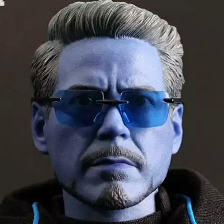

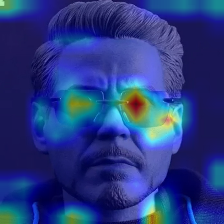

In [26]:
heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( dog)
cv2_imshow(superimposed_img)